# Image Enhancer

In [3]:
# Imports and setup
import os
import time
import random
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

import dataloader

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Paths
DATA_DIR = "../data/Face-Swap-M2-Dataset/dataset/smaller"
OUT_DIR = Path("outputs/gan_enhance")
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "checkpoints").mkdir(exist_ok=True)
(OUT_DIR / "samples").mkdir(exist_ok=True)

Using device: cuda


/home/e20220005499/Documents/Face-Swap-M2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Model: Generator (U-Net with skip connections)
class Generator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base_ch=64):
        super().__init__()
        # Encoder
        self.e1 = nn.Conv2d(in_ch, base_ch, 4, 2, 1)       # 256 -> 128
        self.e2 = nn.Conv2d(base_ch, base_ch*2, 4, 2, 1)   # 128 -> 64
        self.e3 = nn.Conv2d(base_ch*2, base_ch*4, 4, 2, 1) # 64 -> 32
        self.e4 = nn.Conv2d(base_ch*4, base_ch*8, 4, 2, 1) # 32 -> 16
        
        # Decoder (with skip connections)
        self.d1 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 4, 2, 1)   # 16 -> 32
        self.d2 = nn.ConvTranspose2d(base_ch*8, base_ch*2, 4, 2, 1)   # 32 -> 64 (concat e3)
        self.d3 = nn.ConvTranspose2d(base_ch*4, base_ch, 4, 2, 1)     # 64 -> 128 (concat e2)
        self.d4 = nn.ConvTranspose2d(base_ch*2, out_ch, 4, 2, 1)      # 128 -> 256 (concat e1)
        
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encode
        e1 = self.act(self.e1(x))
        e2 = self.act(self.e2(e1))
        e3 = self.act(self.e3(e2))
        e4 = self.act(self.e4(e3))
        
        # Decode with skip connections
        d1 = self.act(self.d1(e4))
        d2 = self.act(self.d2(torch.cat([d1, e3], dim=1)))
        d3 = self.act(self.d3(torch.cat([d2, e2], dim=1)))
        out = self.tanh(self.d4(torch.cat([d3, e1], dim=1)))
        
        return out


# Model: PatchGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_ch=6, base_ch=64):
        super().__init__()
        # Input: concat(degraded_input, target_or_generated) = 6 channels
        self.conv1 = nn.Conv2d(in_ch, base_ch, 4, 2, 1)          # 256 -> 128
        self.conv2 = nn.Conv2d(base_ch, base_ch*2, 4, 2, 1)      # 128 -> 64
        self.conv3 = nn.Conv2d(base_ch*2, base_ch*4, 4, 2, 1)    # 64 -> 32
        self.conv4 = nn.Conv2d(base_ch*4, base_ch*8, 4, 1, 1)    # 32 -> 31
        self.conv5 = nn.Conv2d(base_ch*8, 1, 4, 1, 1)            # 31 -> 30 (patch output)
        
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))
        x = self.conv5(x)
        return x

print('Models defined')

Models defined


In [5]:
# Degradation transforms
class DegradeTransform:
    """Apply random degradation: downscale-upscale + optional blur"""
    def __init__(self, min_scale=0.25, max_scale=0.5, blur_prob=0.0, max_blur_kernel=7):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.blur_prob = blur_prob
        self.max_blur_kernel = max_blur_kernel
    
    def __call__(self, img):
        """img: numpy array HxWxC uint8 RGB"""
        h, w = img.shape[:2]
        
        # Random downscale-upscale
        scale = random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = max(2, int(h * scale)), max(2, int(w * scale))
        small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        degraded = cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Optional blur
        if random.random() < self.blur_prob:
            k = random.randrange(1, self.max_blur_kernel, 2)
            if k > 1:
                degraded = cv2.GaussianBlur(degraded, (k, k), 0)
        
        return degraded

degrade = DegradeTransform(min_scale=0.25, max_scale=0.5, blur_prob=0.0)
print('Degradation transform ready')

Degradation transform ready


In [6]:
# Load data
IMAGE_SIZE = 256
NB_IMAGES = 10
BATCH_SIZE = 8

train_dataset, test_dataset, nb_classes = dataloader.make_dataset(
    DATA_DIR, NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'Train batches: {len(train_loader)}, Test batches: {len(test_loader)}')
print(f'Classes: {nb_classes}')

Building dataset 

Train batches: 9, Test batches: 3
Classes: 10


In [13]:
# Training loop
def train(G, D, opt_G, opt_D, epochs=1000, lr=2e-4, lambda_l1=100.0, save_every=200):

    # Loss functions
    bce_loss = nn.BCEWithLogitsLoss()
    l1_loss = nn.L1Loss()
    
    print(f'Starting training for {epochs} epochs...')
    
    for epoch in range(1, epochs + 1):
        G.train()
        D.train()
        
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0
        start_time = time.time()
        
        for batch_idx, (targets, _) in enumerate(train_loader):
            batch_size = targets.size(0)
            targets = targets.to(device)
            
            # Create degraded inputs
            # Convert tensors [-1,1] -> uint8 RGB
            targets_np = ((targets + 1.0) * 127.5).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype('uint8')
            
            # Apply degradation
            degraded_np = [degrade(img) for img in targets_np]
            
            # Convert back to tensors [-1,1]
            inputs = torch.stack([
                (torch.from_numpy(img.astype('float32') / 255.0).permute(2, 0, 1) - 0.5) / 0.5
                for img in degraded_np
            ]).to(device)
            
            # ============ Train Discriminator ============
            opt_D.zero_grad()
            
            # Generate fake images
            with torch.no_grad():
                fake = G(inputs)
            
            # Real and fake pairs
            real_pair = torch.cat([inputs, targets], dim=1)
            fake_pair = torch.cat([inputs, fake], dim=1)
            
            # Discriminator predictions
            pred_real = D(real_pair)
            pred_fake = D(fake_pair)
            
            # Labels
            real_labels = torch.ones_like(pred_real)
            fake_labels = torch.zeros_like(pred_fake)
            
            # Discriminator loss
            loss_D_real = bce_loss(pred_real, real_labels)
            loss_D_fake = bce_loss(pred_fake, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            
            loss_D.backward()
            opt_D.step()
            
            # ============ Train Generator ============
            opt_G.zero_grad()
            
            # Generate fake images
            fake = G(inputs)
            fake_pair = torch.cat([inputs, fake], dim=1)
            
            # Generator adversarial loss
            pred_fake = D(fake_pair)
            loss_G_adv = bce_loss(pred_fake, real_labels)
            
            # Generator reconstruction loss
            loss_G_l1 = l1_loss(fake, targets)
            
            # Combined generator loss
            loss_G = loss_G_adv + lambda_l1 * loss_G_l1
            
            loss_G.backward()
            opt_G.step()
            
            epoch_loss_G += loss_G.item()
            epoch_loss_D += loss_D.item()
        
        # Epoch stats
        avg_loss_G = epoch_loss_G / len(train_loader)
        avg_loss_D = epoch_loss_D / len(train_loader)
        epoch_time = time.time() - start_time
        
        print(f'Epoch [{epoch}/{epochs}] | G_loss: {avg_loss_G:.4f} | D_loss: {avg_loss_D:.4f} | Time: {epoch_time:.1f}s')
        
        # Save checkpoint
        if epoch % save_every == 0:
            checkpoint = {
            'epoch': epoch,
            'G_state': G.state_dict(),
            'D_state': D.state_dict(),
            'opt_G_state': opt_G.state_dict(),
            'opt_D_state': opt_D.state_dict(),
            }
            torch.save(checkpoint, OUT_DIR / f'checkpoints/epoch_{epoch}.pth')
            
            """ # Save sample images using the test set
            G.eval()
            with torch.no_grad():
                test_inputs, test_targets = next(iter(test_loader))
                test_inputs = test_inputs.to(device)
                test_targets = test_targets.to(device)
                sample_fakes = G(test_inputs).cpu()
                
                # Ensure all tensors have the same dimensions
                test_inputs = test_inputs.cpu()
                test_targets = test_targets.cpu()
                if sample_fakes.dim() == 3:  # Add batch dimension if missing
                    sample_fakes = sample_fakes.unsqueeze(0)
                
                # Adjust dimensions to ensure compatibility
                if test_inputs.dim() == 3:
                    test_inputs = test_inputs.unsqueeze(0)
                if test_targets.dim() == 3:
                    test_targets = test_targets.unsqueeze(0)
                
                # Create grid: input | generated | target
                comparison = torch.cat([test_inputs, sample_fakes, test_targets], dim=0)
                grid = make_grid(comparison, nrow=8, normalize=True, value_range=(-1, 1))
                save_image(grid, OUT_DIR / f'samples/epoch_{epoch}.png')
                G.train() """


print('Training function ready')

Training function ready


In [17]:
# Initialize models
G = Generator(base_ch=128).to(device)
D = Discriminator(base_ch=128).to(device)
lr = 2e-4
# Optimizers
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [20]:
# Run training
EPOCHS = 500

LAMBDA_L1 = 200.0

train(G,D, opt_G, opt_D,epochs=EPOCHS, lr=lr, lambda_l1=LAMBDA_L1, save_every=200)
print('Training complete!')

Starting training for 500 epochs...
Epoch [1/500] | G_loss: 6.7887 | D_loss: 0.6916 | Time: 1.7s
Epoch [2/500] | G_loss: 6.6338 | D_loss: 0.6917 | Time: 1.6s
Epoch [3/500] | G_loss: 7.0264 | D_loss: 0.6903 | Time: 1.6s
Epoch [4/500] | G_loss: 6.6252 | D_loss: 0.6938 | Time: 1.6s
Epoch [5/500] | G_loss: 6.7560 | D_loss: 0.6912 | Time: 1.6s
Epoch [6/500] | G_loss: 6.8632 | D_loss: 0.6963 | Time: 1.6s
Epoch [7/500] | G_loss: 6.9001 | D_loss: 0.6928 | Time: 1.6s
Epoch [8/500] | G_loss: 6.5831 | D_loss: 0.6925 | Time: 1.6s
Epoch [9/500] | G_loss: 6.8449 | D_loss: 0.6919 | Time: 1.6s
Epoch [10/500] | G_loss: 6.4506 | D_loss: 0.6931 | Time: 1.6s
Epoch [11/500] | G_loss: 6.8398 | D_loss: 0.6927 | Time: 1.6s
Epoch [12/500] | G_loss: 6.8486 | D_loss: 0.6922 | Time: 1.6s
Epoch [13/500] | G_loss: 6.3895 | D_loss: 0.6971 | Time: 1.6s
Epoch [14/500] | G_loss: 6.4885 | D_loss: 0.6922 | Time: 1.6s
Epoch [15/500] | G_loss: 6.9217 | D_loss: 0.6922 | Time: 1.6s
Epoch [16/500] | G_loss: 6.4873 | D_loss: 0

In [12]:
# Load checkpoint
def load_checkpoint(checkpoint_path, generator, discriminator, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['G_state'])
    discriminator.load_state_dict(checkpoint['D_state'])
    print(f'Checkpoint loaded from {checkpoint_path}')

# Example usage
checkpoint_path = OUT_DIR / 'checkpoints/epoch_2600.pth'
load_checkpoint(checkpoint_path, G, D, device)

Checkpoint loaded from outputs/gan_enhance/checkpoints/epoch_2600.pth


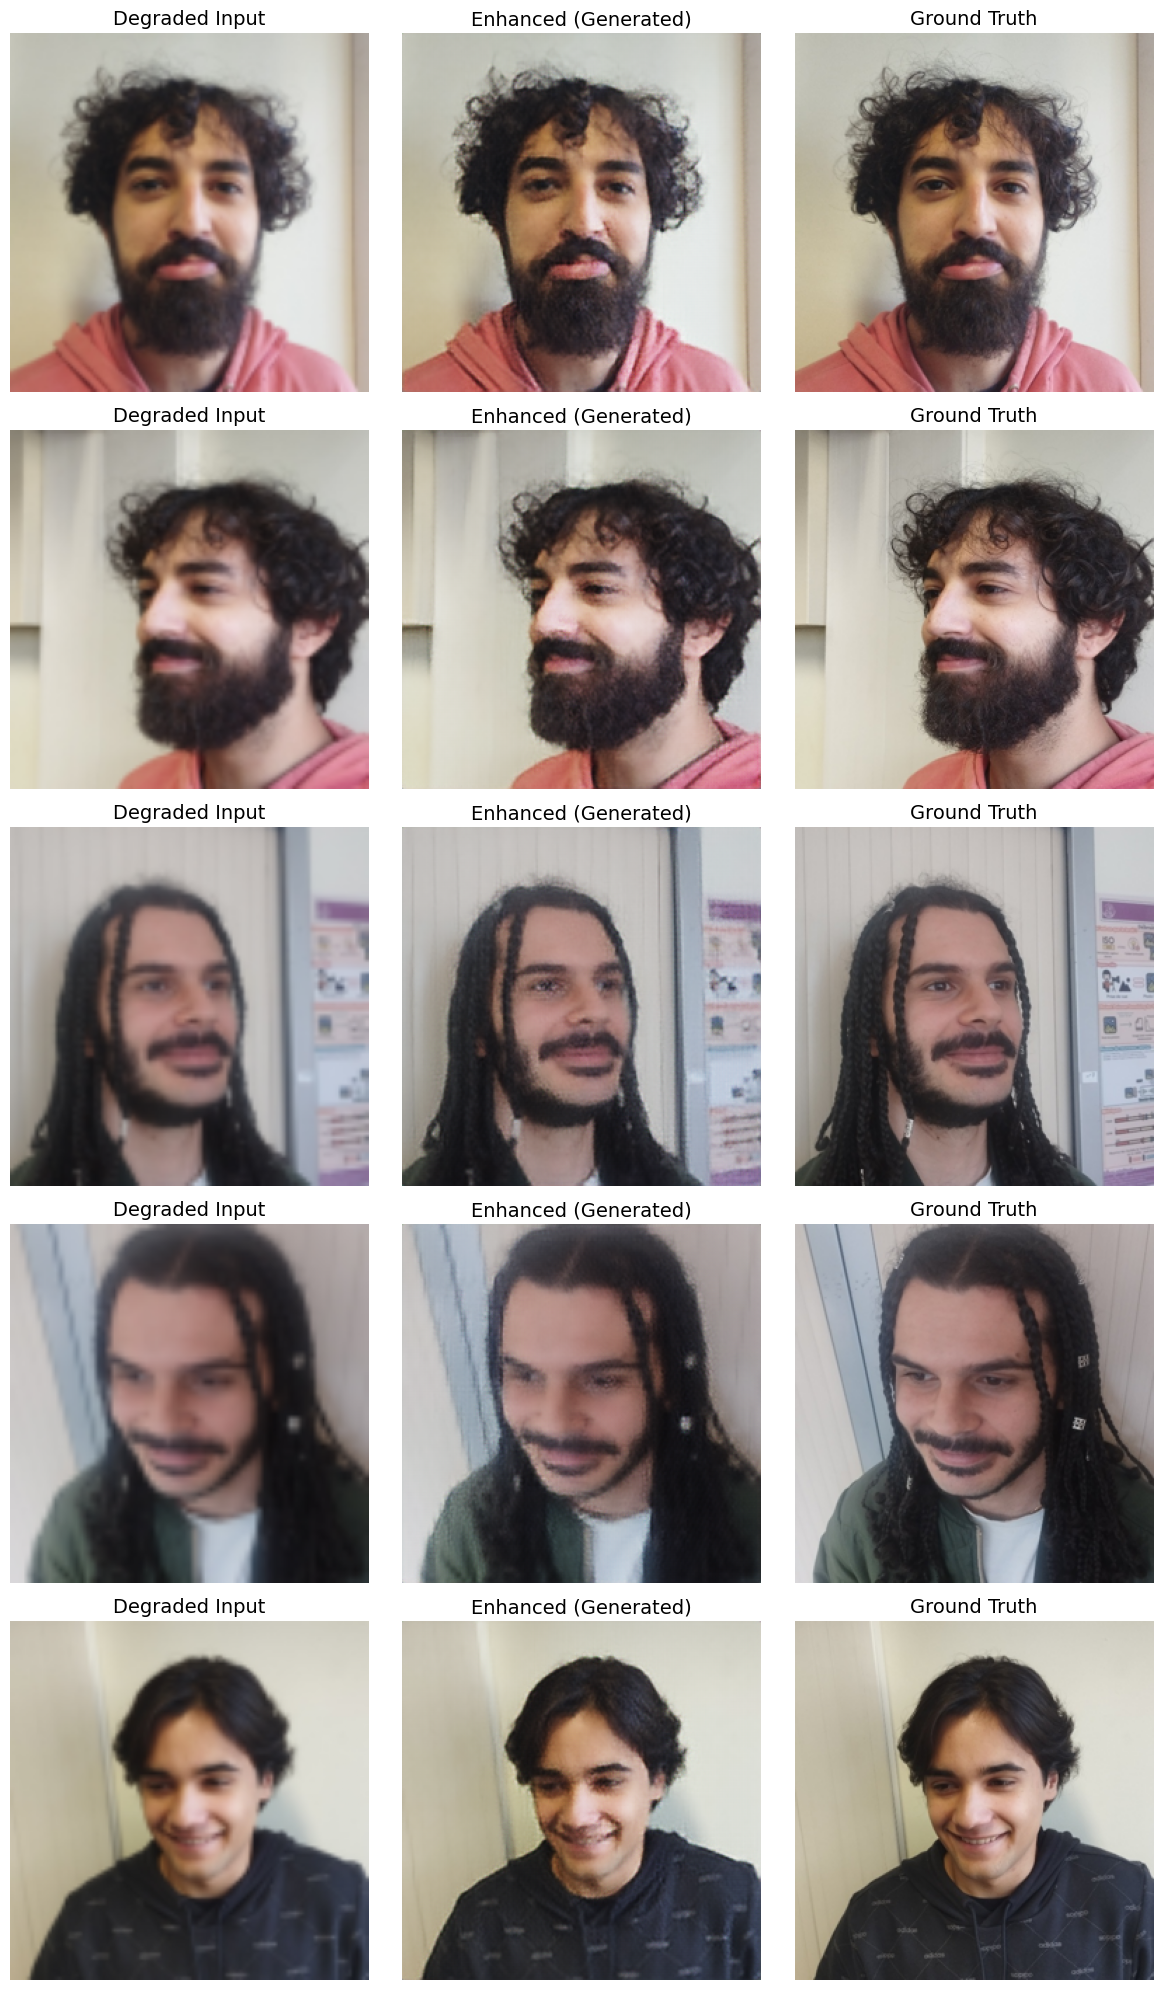

Results saved to outputs/gan_enhance/test_results.png


In [21]:
# Plot results on test data
def plot_results(generator, num_samples=5):
    generator.eval()
    
    # Get a batch from test set
    targets, _ = next(iter(test_loader))
    targets = targets[:num_samples].to(device)
    
    # Create degraded inputs
    targets_np = ((targets + 1.0) * 127.5).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype('uint8')
    degraded_np = [degrade(img) for img in targets_np]
    inputs = torch.stack([
        (torch.from_numpy(img.astype('float32') / 255.0).permute(2, 0, 1) - 0.5) / 0.5
        for img in degraded_np
    ]).to(device)
    
    # Generate enhanced images
    with torch.no_grad():
        enhanced = generator(inputs)
    
    # Convert to numpy for plotting
    inputs_np = (inputs.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5).clip(0, 1)
    enhanced_np = (enhanced.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5).clip(0, 1)
    targets_np = (targets.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5).clip(0, 1)
    
    # Plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        axes[i, 0].imshow(inputs_np[i])
        axes[i, 0].set_title('Degraded Input', fontsize=14)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(enhanced_np[i])
        axes[i, 1].set_title('Enhanced (Generated)', fontsize=14)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(targets_np[i])
        axes[i, 2].set_title('Ground Truth', fontsize=14)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'test_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Results saved to {OUT_DIR / "test_results.png"}')

# Generate and plot results
plot_results(G, num_samples=5)